In [1]:
import tobler
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.options.display.max_columns = 1000      # set column display
pd.options.display.max_rows = 1000         # set row display
pd.options.mode.chained_assignment = None  # default='warn'

# LandScan population statistics for day and nighttime, aggregated to hexes
hexes     = gpd.read_file('../data/shapefiles/nyc/population_hexbinned.geojson')

# table of in-/out-flow taxi rides per taxi zone, hour/day/month
rides     = pd.read_csv('../data/tables/fhv19.csv')

# taxi zone shapefile
tz        = gpd.read_file('../data/shapefiles/nyc/taxi_zones.geojson')\
               .to_crs(hexes.crs)
keep_cols = ['location_id', 'zone', 'geometry']
tz        = tz[keep_cols] # filter columns

# renaming tz column and resetting type to int
tz.rename(columns={'location_id': 'taxizoneID'},
          inplace=True)
tz['taxizoneID'] = tz['taxizoneID'].astype(int)

# fixing data duplication error in the TZ dataset
tz.iloc[56,  tz.columns.get_loc('taxizoneID')] = 57
tz.iloc[103, tz.columns.get_loc('taxizoneID')] = 104
tz.iloc[104, tz.columns.get_loc('taxizoneID')] = 105

In [2]:
rides['month']  = rides.apply(lambda row: row['time'].split('/')[0], axis=1)
rides['day']    = rides.apply(lambda row: row['time'].split('/')[1], axis=1)
rides['night?'] = rides.apply(lambda row: 0 if row['timegroupstr'] == 'daytime' else 1, axis=1)

rides['month']  = rides['month'].astype(int)
rides['day']    = rides['day'].astype(int)
rides['night?'] = rides['night?'].astype(int)

In [3]:
# pivot table to sum day/night rides by taxi zone, day, and month
table = pd.pivot_table(rides,
                       values=['inflow_counts', 'outflow_counts'],
                       index=['taxizoneID', 'month', 'day', 'weekday', 'night?'],
                       aggfunc=np.sum).reset_index()

In [4]:
# summary stats and quick head view
print(f"{table.shape[0]} total records in the rides dataset.")
print(f"{len(table.taxizoneID.unique())} total taxi zones represented over "
     + f"{len(table.month.unique())} months in 2019.")
print()
table.head()

63383 total records in the rides dataset.
263 total taxi zones represented over 5 months in 2019.



,taxizoneID,month,day,weekday,night?,inflow_counts,outflow_counts
0,1,1,1,Tuesday,0,4038,153
1,1,1,1,Tuesday,1,234,85
2,1,1,2,Wednesday,0,3821,139
3,1,1,2,Wednesday,1,284,72
4,1,1,3,Thursday,0,2702,76


,taxizoneID,zone,geometry,month,day,weekday,night?,inflow_counts,outflow_counts
0,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,1,Tuesday,0,4038,153
1,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,1,Tuesday,1,234,85
2,1,Newark Airport,"MULTIPOLYGON (((284409.729 58685.116, 284406.7...",1,2,Wednesday,0,3821,139


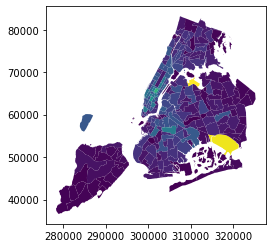

In [5]:
tz_merged = tz.merge(table, on='taxizoneID', how='right')

tz_merged[(tz_merged['month'] == 3) &\
          (tz_merged['day'] == 1) &\
          (tz_merged['night?'] == 0)].plot(column='inflow_counts');

tz_merged.head(3)

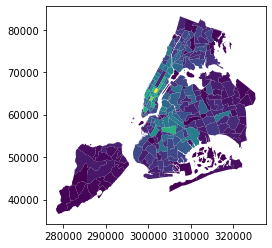

In [6]:
# filter out airports from study area and see how map changes
tz_no_airports = tz_merged[~tz_merged['zone'].str.contains('Airport')]

tz_no_airports[(tz_no_airports['month'] == 3) &\
               (tz_no_airports['day'] == 1) &\
               (tz_no_airports['night?'] == 0)].plot(column='inflow_counts');

Create output DF for records after iteration: 

| taxizoneID | zone | geometry | month | day | weekday | night? | inflow_counts | outflow_counts |
|------------|------|----------|-------|-----|---------|--------|---------------|----------------|

Group hexbin records by `month`/`day`/`night?`:
* For each unique combination of the above, interpolate counts
* Append interpolated count values, merge to output DF

In [7]:
# Create a UID column for our Taxi Zone (less airports) data

tz_no_airports['uid'] = tz_no_airports['month'].astype(str) +\
                        tz_no_airports['day'].astype(str) +\
                        tz_no_airports['night?'].astype(str)

tz_no_airports.sort_values(['uid', 'taxizoneID'],
                           ascending=True)\
              .head(2)

,taxizoneID,zone,geometry,month,day,weekday,night?,inflow_counts,outflow_counts,uid
241,2,Jamaica Bay,"MULTIPOLYGON (((314941.095 52464.112, 314993.0...",1,1,Tuesday,0,0,0,110
482,3,Allerton/Pelham Gardens,"MULTIPOLYGON (((312819.539 78262.951, 312876.4...",1,1,Tuesday,0,576,582,110


In [8]:
# Create our target GDF to append to as we iterate
# through UIDs and perform areal interpolation
cols = ['uid', 'month', 'day', 'night?', 'weekday',
        'inflow_counts', 'outflow_counts', 'geometry']

hexes_taxidemand = gpd.GeoDataFrame(columns=cols) # target output GDF

# get our UIDs and set up our cleaned hexes DF to populate on each iteration
uids = tz_no_airports['uid'].unique() # unique month/day/night? pairs in dataset
sel_cols = ['hex_id_8', 'night_pop', 'day_pop', 'geometry']
clean_hexes = hexes[sel_cols].copy()

for uid in uids: # for each of the UIDs (month/day/night?) represented in our TZ data
    uid_subset = tz_no_airports[tz_no_airports['uid'] == uid]
    hex_subset = clean_hexes.copy()
    
    # areal interpolation using Tobler: disaggregate ridership from TZs to hexes
    estimates = tobler.area_weighted.area_interpolate(uid_subset,
                                                      hexes,
                                                      extensive_variables=\
                                                          ['inflow_counts','outflow_counts'])
    
    # add outcome of our areal interpolation as a feature
    hex_subset['inflow_counts']  = estimates['inflow_counts'].astype(int)
    hex_subset['outflow_counts'] = estimates['outflow_counts'].astype(int)
    
    # fill rest of hex info based on TZ (already selected by `uid`)
    hex_subset['uid']     = uid
    hex_subset['month']   = uid_subset.iloc[1]['month']
    hex_subset['day']     = uid_subset.iloc[1]['day']
    hex_subset['night?']  = uid_subset.iloc[1]['night?']
    hex_subset['weekday'] = uid_subset.iloc[1]['weekday']
    
    
    hexes_taxidemand = hexes_taxidemand.append(hex_subset)

In [9]:
print(hexes_taxidemand.shape[0] / hexes.shape[0])
hexes_taxidemand.head(2)

241.0


,uid,month,day,night?,weekday,inflow_counts,outflow_counts,geometry,hex_id_8,night_pop,day_pop
0,110,1,1,0,Tuesday,7,7,"POLYGON ((309177.150 70241.423, 308638.240 701...",882a100f47fffff,4581.0,5304.0
1,110,1,1,0,Tuesday,0,0,"POLYGON ((309756.428 68989.222, 310295.305 691...",882a100f43fffff,8570.0,10200.0


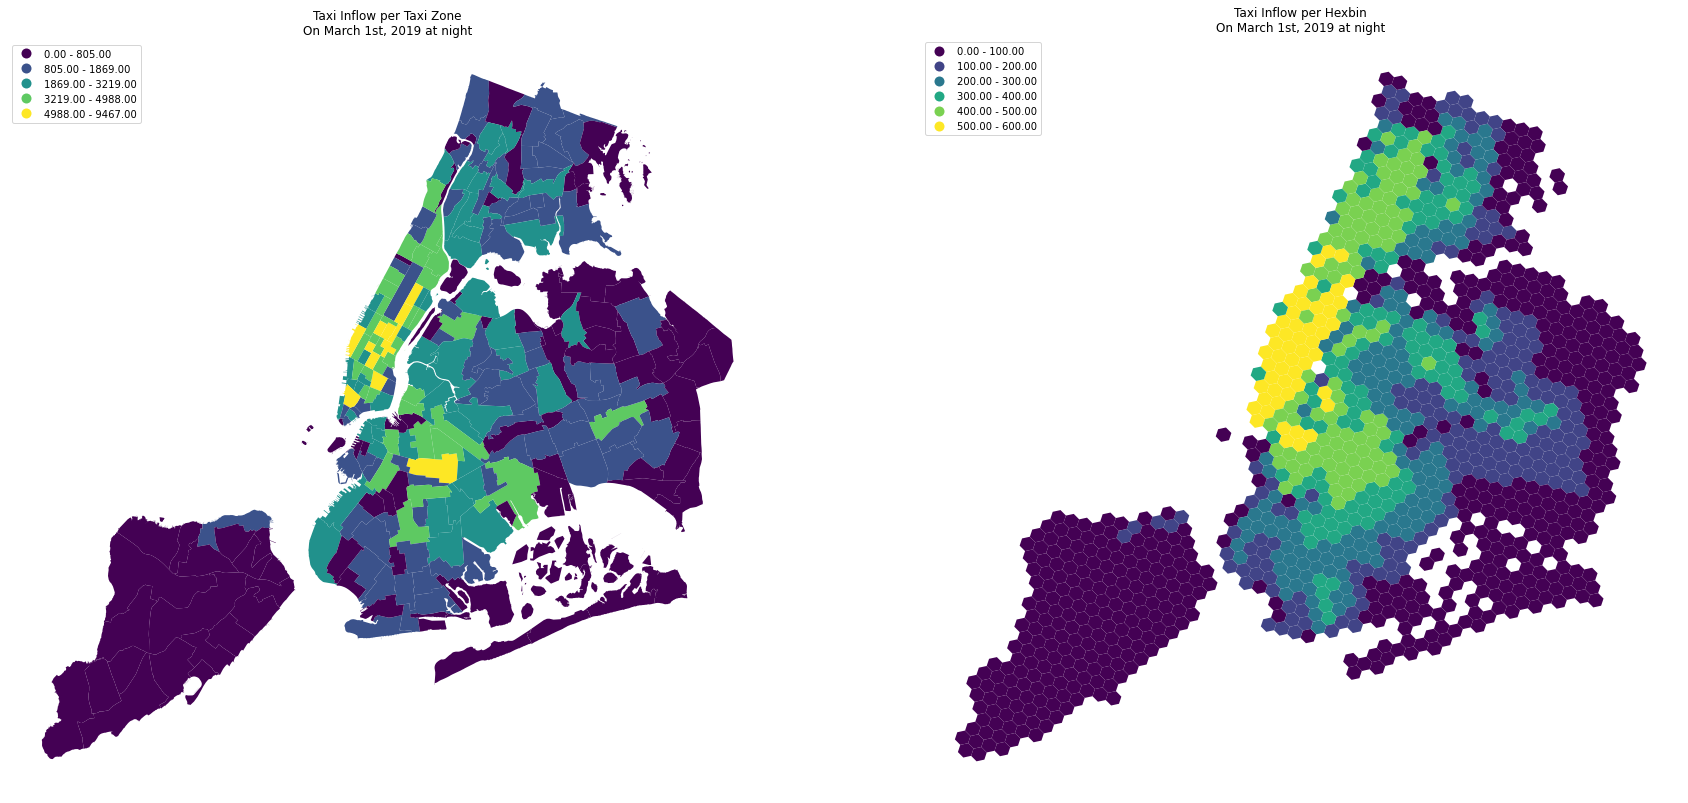

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (30, 40))

ax[0].axis('off')
ax[0].set_title('Taxi Inflow per Taxi Zone\nOn March 1st, 2019 at night');

ax[1].axis('off')
ax[1].set_title('Taxi Inflow per Hexbin\nOn March 1st, 2019 at night');

# inflow per TZ on march 1st (friday) during the day
sel_data = tz_no_airports[(tz_no_airports['month'] == 3) &\
                          (tz_no_airports['day'] == 1) &\
                          (tz_no_airports['night?'] == 0)]

sel_data.plot(column      = 'inflow_counts',
              ax          = ax[0],
              legend      = True,
              legend_kwds = {'loc': 'upper left'},
              scheme      = 'Fisher_Jenks')

# inflow per hexbin on march 1st (friday) during the day
sel_data = hexes_taxidemand[(hexes_taxidemand['month'] == 3) &\
                            (hexes_taxidemand['day'] == 1) &\
                            (hexes_taxidemand['night?'] == 0)]

sel_data.plot(column      = 'inflow_counts',
              ax          = ax[1],
              legend      = True,
              legend_kwds = {'loc': 'upper left'},
              cmap        = 'viridis',
              scheme      = 'user_defined',
              classification_kwds = {'bins':[100, 200, 300, 400, 500, 600]});
plt.show();

In [12]:
hexes_taxidemand.to_file("../data/shapefiles/nyc/hexes_taxidemand.geojson",
                         driver='GeoJSON')

## Notes

#### Nick: PLUTO (land use/built env), taxi demand (2019), population counts, venue counts, weather
#### Kaifu: citibike, MTA

Notes from Jia:
* https://www.tandfonline.com/doi/abs/10.1080/01944361003766766
* Some thoughts on feature selection: Given the time limitation, it would not be realistic to dive too deep into all the literatures on factors that influence travel behaviors and drive up the demand. However, it is worth looking into some built environment features and how those attributes play into your research question. If you are interested to learn more about travel behaviors and built environment, Ewing and Cervero have a very good piece that summarizes some major findings on this topic. Some general categories to investigate include land use, walkability, venue density etc.
* Analyzing the OD data of different modes might also be helpful. What are the popular origins and destinations? Any commonalities? Maybe there are some patterns?
* First/last mile travel
* Based on the assumption that walking is the most common first/last-mile travel mode, especially during nighttime, features that contribute to walkability are worth investigating.